# Setting

In [1]:
from pf_utils import DataManager, BacktestManager
from pf_widgets import WidgetUniverse, WidgetTransaction

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
path_data = 'data'
path_comp = 'data/kospi200'

In [3]:
col_ticker = '종목코드'
col_date = 'date'

# Components

In [4]:
import pandas as pd
import re
from pf_utils import get_file_list

In [5]:
file = 'kospi200_components'
files = get_file_list(file, path_comp)
files

['kospi200_components_040102.csv',
 'kospi200_components_050103.csv',
 'kospi200_components_060102.csv',
 'kospi200_components_070102.csv',
 'kospi200_components_080102.csv',
 'kospi200_components_090102.csv',
 'kospi200_components_100104.csv',
 'kospi200_components_110103.csv',
 'kospi200_components_120102.csv',
 'kospi200_components_130102.csv',
 'kospi200_components_140102.csv',
 'kospi200_components_150102.csv',
 'kospi200_components_160104.csv',
 'kospi200_components_170102.csv',
 'kospi200_components_180102.csv',
 'kospi200_components_190102.csv',
 'kospi200_components_200102.csv',
 'kospi200_components_210104.csv',
 'kospi200_components_220103.csv',
 'kospi200_components_230102.csv',
 'kospi200_components_240102.csv']

In [8]:
get_date = lambda x: '20' + re.search(r'\_(\d{6})\.', x).group(1)

df_comp = pd.DataFrame()
for f in files:
    date = get_date(f)
    f = f'{path_comp}/{f}'
    df = pd.read_csv(f, dtype={col_ticker:str})
    df = df.assign(date=date)
    df_comp = pd.concat([df_comp, df])

df_comp[col_date] = pd.to_datetime(df_comp[col_date])

In [9]:
tickers_all = df_comp[col_ticker].unique()
len(tickers_all)

439

# Price

## Download

In [10]:
WidgetUniverse

In [11]:
start_date = df_comp[col_date].min().strftime('%Y-%m-%d')
end_date = df_comp[col_date].max().strftime('%Y-%m-%d')
start_date, end_date

('2004-01-02', '2024-01-02')

In [12]:
uv_k2hl = ['krx', 'kospi200_prices_040102_241023.csv']

In [13]:
k2hl = DataManager(
    path = path_data,
    **dict(zip(['universe', 'file'], uv_k2hl))
)
k2hl.upload()

In [14]:
kw = dict(
    start_date=start_date, tickers=tickers_all,
    close_today = WidgetUniverse.values(1),
    interval=5, pause_duration=1, msg=False
)
k2hl.download(**kw) if WidgetUniverse.values(0) else None

REMINDER: 439 tickers set regardless of market


100%|█████████████████████████████████████████████████████████████| 439/439 [01:36<00:00,  4.55it/s]


1.6 mins elapsed, 18.0 secs paused (18.7%)
... done
426 assets from 2004-01-02 to 2024-10-23 downloaded.
kospi200_prices_040102_241023.csv saved
df_prices updated
Execution time of download: 96.92 secs


In [37]:
#k2hl.save()

kospi200_prices_bt_040102_241024.csv saved


In [15]:
df_k2hl = k2hl.df_prices

In [16]:
df_k2hl.isna().sum().sum() / df_k2hl.size

0.18001800508744153

## Listing by Year

In [17]:
# drop tickers of no data
df_comp2 = df_comp.loc[df_comp[col_ticker].isin(df_k2hl.columns)]

In [18]:
for year in df_comp2[col_date].dt.year.unique():
    # get list of kospi200 in year
    t_all = df_comp2.loc[df_comp2[col_date].dt.year == year, col_ticker]
    # get tickers of non kospi200 in year and set their prices to None
    t_exc = df_k2hl.columns.difference(t_all)
    df_k2hl.loc[df_k2hl.index.year == year, t_exc] = None

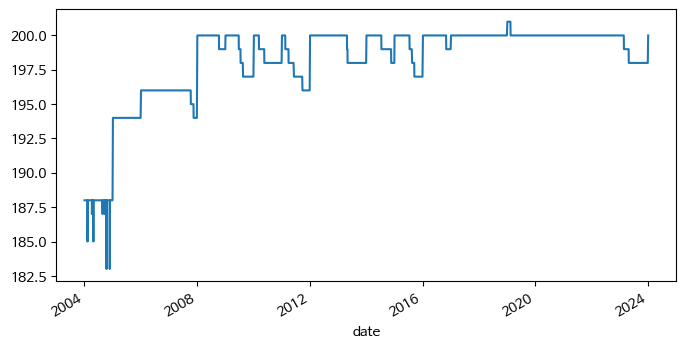

In [19]:
start, end = df_comp2[col_date].min(), df_comp2[col_date].max()
_ = df_k2hl.loc[start:end].notna().sum(axis=1).plot(figsize=(8,4))

In [44]:
#k2hl.df_prices.loc[start:end].notna().sum(axis=1).plot()

In [20]:
uv_k2hl

['krx', 'kospi200_prices_040102_241023.csv']

In [21]:
file = 'kospi200_prices_bt_040102_241023.csv'
df_k2hl.to_csv(f'{path_data}/{file}')

# Usage

## Data

In [22]:
uv_k2hl = ['krx', 'kospi200_prices_bt_040102_241023.csv']

In [23]:
k2hl = DataManager(
    path = path_data,
    **dict(zip(['universe', 'file'], uv_k2hl))
)
k2hl.upload()

426 assets from 2004-01-02 to 2024-10-23 uploaded.
df_prices updated


In [24]:
df_k2hl = k2hl.df_prices.ffill()
assetnames_k2hl = k2hl.get_names()

ERROR from get_names: '060000'


## Backtest

In [25]:
n_val = 200
lookback = 260

df = df_k2hl.ffill()

df_train = df.iloc[:-n_val]
df_val = df.iloc[-n_val-lookback:]

In [32]:
kwargs_bm = dict(
    initial_capital = 1e8,
    commissions = 0,
    align_axis = None, 
    days_in_year = 245,
    asset_names = assetnames_k2hl
)

In [41]:
bm = BacktestManager(df_val, **kwargs_bm)

lags = dict(lookback='6M', lag='10D')
#lags = dict(lookback=6, lag=10)
bm.benchmark_ticker(**lags)

426 assets from 2022-12-06 to 2024-10-23 uploaded.
running self.util_check_days_in_year to check days in a year
Benchmark is KODEX200


Backtesting 2 strategies: KODEX200, K2HL


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.79it/s]

Returning stats


,KODEX200,K2HL
start,2022-12-05,2022-12-05
end,2024-10-23,2024-10-23
total_return,0.03874,-0.178994
cagr,0.020383,-0.099409
calmar,0.123703,-0.232357
max_drawdown,-0.164775,-0.427829
avg_drawdown,-0.034289,-0.114778
avg_drawdown_days,25.0,92.2
daily_vol,0.162657,0.330132
daily_sharpe,0.210015,-0.161715


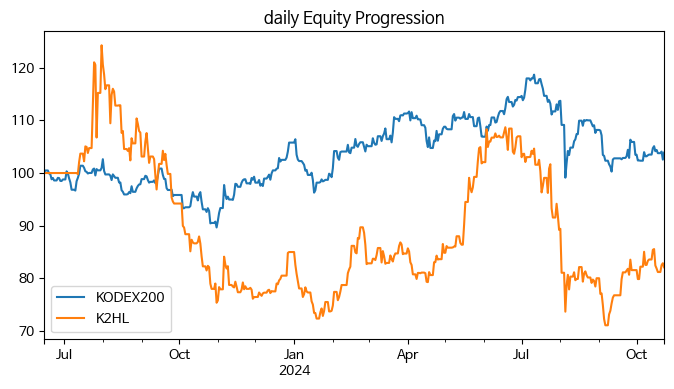

In [42]:
kwargs_build = dict(
    name='K2HL', select='Momentum', weigh='Equally', 
    n_assets=5, freq='M', **lags
)
bm.build(**kwargs_build)

bm.run(stats_sort_by='cagr', figsize=(8,4))

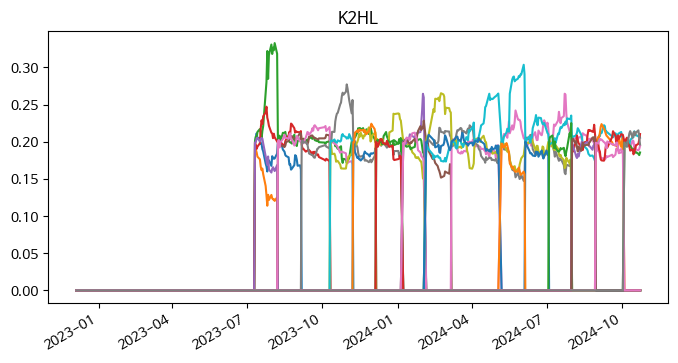

In [40]:
bm.plot_security_weights(1, legend=False, figsize=(8,4))